In [1]:
import os
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2

In [2]:
# setting the diretory paths 
dataset_path = "D:/Masters/Sem 3/Deep learning/data/" # my main directory
images_path = Path(dataset_path) / "pets_data/images" # image folder 
annotations_path = Path(dataset_path) / "pets_anno/annotations/xmls" # annotation folder

In [3]:
# Collect unique class names
classes = set()
for xml_file in annotations_path.glob('*.xml'):
    # using element tree to get parse all the xml tags 
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes.add(class_name)

In [4]:
classes = sorted(list(classes))
print("Classes in the dataset:", classes)
print("Number of classes:", len(classes))

Classes in the dataset: ['cat', 'dog']
Number of classes: 2


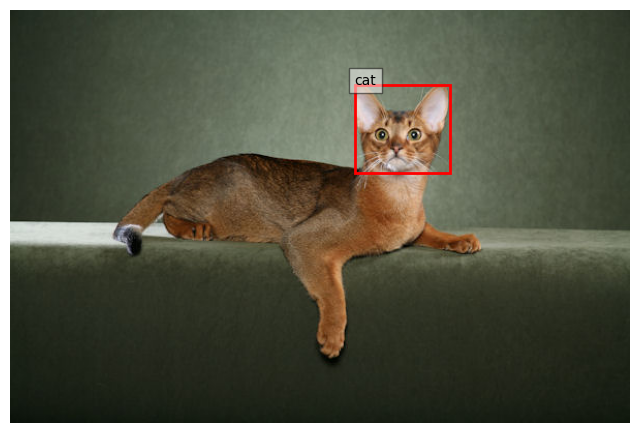

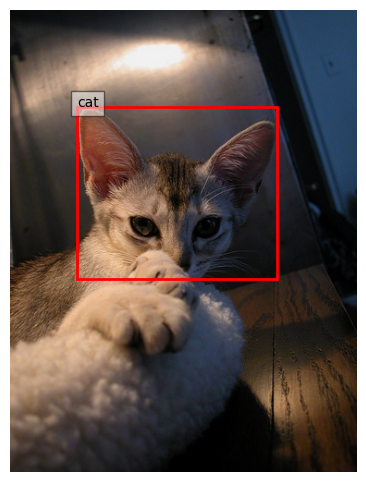

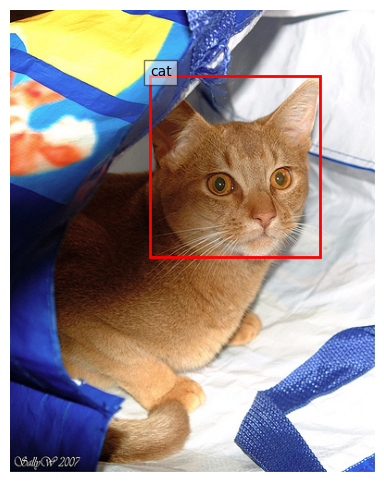

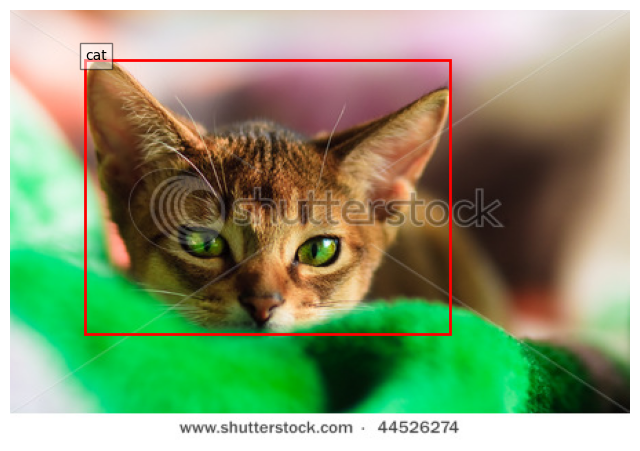

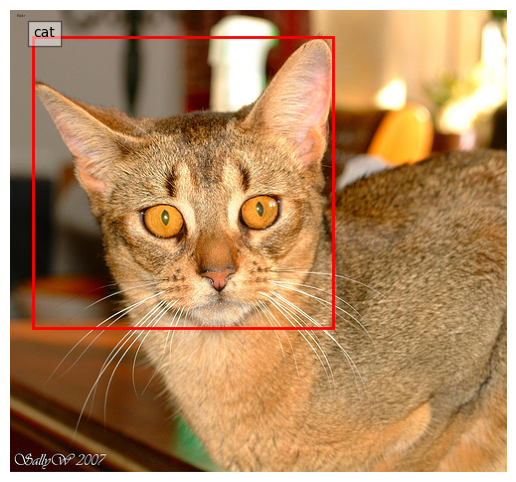

In [5]:
# used internet for this 
# first 5 XML files for visualization
xml_files = list(annotations_path.glob('*.xml'))[:5]

for xml_file in xml_files:
    # Get corresponding image file 
    base_name = xml_file.stem  # e.g., "Abyssinian_1"
    image_file = images_path / (base_name + '.jpg')
    
    # Load image
    image = Image.open(image_file).convert("RGB")
    
    # Parse XML
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    ax = plt.gca()
    
    # Draw bounding boxes
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        
        # Calculate width and height
        width = xmax - xmin
        height = ymax - ymin
        
        # Draw rectangle
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
        # Add class label
        plt.text(xmin, ymin, class_name, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.axis('off')
    plt.show()

In [6]:
from sklearn.model_selection import train_test_split

xml_files = list(annotations_path.glob('*.xml'))

train_val, test = train_test_split(xml_files, test_size=0.15, random_state=42)
val_fraction = 0.15 / (1 - 0.15)  
train, val = train_test_split(train_val, test_size=val_fraction, random_state=42)

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 2580, Validation: 553, Test: 553


In [7]:
# data loading using pytorch dataset class
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class PetDataset(Dataset):
    def __init__(self, xml_files, images_path, class_to_idx, transforms=None):
        self.xml_files = xml_files
        self.images_path = images_path
        self.class_to_idx = class_to_idx
        self.transforms = transforms

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = self.xml_files[idx]
        base_name = xml_file.stem
        image_file = self.images_path / (base_name + '.jpg')
        
        # Load image
        image = Image.open(image_file).convert("RGB")
        
        # Parse XML
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            label = self.class_to_idx[class_name]
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        
        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx], dtype=torch.int64)
        }
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, target

# Create class-to-index mapping (labels start from 1, 0 is background)
class_to_idx = {cls: idx + 1 for idx, cls in enumerate(classes)}

# Define transforms
transforms = T.ToTensor()

# Create datasets
train_dataset = PetDataset(train, images_path, class_to_idx, transforms)
val_dataset = PetDataset(val, images_path, class_to_idx, transforms)
test_dataset = PetDataset(test, images_path, class_to_idx, transforms)

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the box predictor for our number of classes
num_classes = len(classes) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cappr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch.optim as optim

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

num_epochs = 10
print_interval = 2  # Print every 2% of the epoch

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    total_batches = len(train_loader)
    last_printed = 0  # Track the last printed percentage

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        train_loss += losses.item()
        
        # Calculate current percentage of epoch completed
        current_percentage = (batch_idx + 1) / total_batches * 100
        
        # Print progress if 2% or more has passed since last print or if it's the last batch
        if current_percentage - last_printed >= print_interval or batch_idx == total_batches - 1:
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{total_batches}, "
                  f"Progress: {current_percentage:.2f}%, Loss: {losses.item():.4f}")
            last_printed = current_percentage
    
    # Print average training loss for the epoch
    avg_train_loss = train_loss / total_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)
            preds = [{k: v.cpu() for k, v in output.items()} for output in outputs]
            targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
            metric.update(preds, targets_cpu)
    
    map_values = metric.compute()
    print(f"Validation mAP@0.5: {map_values['map_50']:.4f}, mAP@0.5:0.95: {map_values['map']:.4f}")
    
    scheduler.step()

Epoch 1/10, Batch 26/1290, Progress: 2.02%, Loss: 0.3005
Epoch 1/10, Batch 52/1290, Progress: 4.03%, Loss: 0.1617
Epoch 1/10, Batch 78/1290, Progress: 6.05%, Loss: 0.2399
Epoch 1/10, Batch 104/1290, Progress: 8.06%, Loss: 0.1607
Epoch 1/10, Batch 130/1290, Progress: 10.08%, Loss: 0.1587
Epoch 1/10, Batch 156/1290, Progress: 12.09%, Loss: 0.1149
Epoch 1/10, Batch 182/1290, Progress: 14.11%, Loss: 0.0862
Epoch 1/10, Batch 208/1290, Progress: 16.12%, Loss: 0.1851
Epoch 1/10, Batch 234/1290, Progress: 18.14%, Loss: 0.0801
Epoch 1/10, Batch 260/1290, Progress: 20.16%, Loss: 0.1080
Epoch 1/10, Batch 286/1290, Progress: 22.17%, Loss: 0.0751
Epoch 1/10, Batch 312/1290, Progress: 24.19%, Loss: 0.1060
Epoch 1/10, Batch 338/1290, Progress: 26.20%, Loss: 0.0839
Epoch 1/10, Batch 364/1290, Progress: 28.22%, Loss: 0.1142
Epoch 1/10, Batch 390/1290, Progress: 30.23%, Loss: 0.0941
Epoch 1/10, Batch 416/1290, Progress: 32.25%, Loss: 0.1275
Epoch 1/10, Batch 442/1290, Progress: 34.26%, Loss: 0.1461
Epoc

Epoch 3/10, Batch 962/1290, Progress: 74.57%, Loss: 0.0655
Epoch 3/10, Batch 988/1290, Progress: 76.59%, Loss: 0.0400
Epoch 3/10, Batch 1014/1290, Progress: 78.60%, Loss: 0.0400
Epoch 3/10, Batch 1040/1290, Progress: 80.62%, Loss: 0.0608
Epoch 3/10, Batch 1066/1290, Progress: 82.64%, Loss: 0.0478
Epoch 3/10, Batch 1092/1290, Progress: 84.65%, Loss: 0.0369
Epoch 3/10, Batch 1118/1290, Progress: 86.67%, Loss: 0.0535
Epoch 3/10, Batch 1144/1290, Progress: 88.68%, Loss: 0.0406
Epoch 3/10, Batch 1170/1290, Progress: 90.70%, Loss: 0.0453
Epoch 3/10, Batch 1196/1290, Progress: 92.71%, Loss: 0.0337
Epoch 3/10, Batch 1222/1290, Progress: 94.73%, Loss: 0.0456
Epoch 3/10, Batch 1248/1290, Progress: 96.74%, Loss: 0.0328
Epoch 3/10, Batch 1274/1290, Progress: 98.76%, Loss: 0.0996
Epoch 3/10, Batch 1290/1290, Progress: 100.00%, Loss: 0.0351
Epoch 3/10, Average Training Loss: 0.0500
Validation mAP@0.5: 0.9923, mAP@0.5:0.95: 0.7961
Epoch 4/10, Batch 26/1290, Progress: 2.02%, Loss: 0.0521
Epoch 4/10, B

Epoch 6/10, Batch 546/1290, Progress: 42.33%, Loss: 0.0227
Epoch 6/10, Batch 572/1290, Progress: 44.34%, Loss: 0.0272
Epoch 6/10, Batch 598/1290, Progress: 46.36%, Loss: 0.0208
Epoch 6/10, Batch 624/1290, Progress: 48.37%, Loss: 0.0268
Epoch 6/10, Batch 650/1290, Progress: 50.39%, Loss: 0.0246
Epoch 6/10, Batch 676/1290, Progress: 52.40%, Loss: 0.0238
Epoch 6/10, Batch 702/1290, Progress: 54.42%, Loss: 0.0266
Epoch 6/10, Batch 728/1290, Progress: 56.43%, Loss: 0.0166
Epoch 6/10, Batch 754/1290, Progress: 58.45%, Loss: 0.0445
Epoch 6/10, Batch 780/1290, Progress: 60.47%, Loss: 0.0533
Epoch 6/10, Batch 806/1290, Progress: 62.48%, Loss: 0.0139
Epoch 6/10, Batch 832/1290, Progress: 64.50%, Loss: 0.0298
Epoch 6/10, Batch 858/1290, Progress: 66.51%, Loss: 0.0224
Epoch 6/10, Batch 884/1290, Progress: 68.53%, Loss: 0.0195
Epoch 6/10, Batch 910/1290, Progress: 70.54%, Loss: 0.0206
Epoch 6/10, Batch 936/1290, Progress: 72.56%, Loss: 0.0187
Epoch 6/10, Batch 962/1290, Progress: 74.57%, Loss: 0.01

Epoch 9/10, Batch 130/1290, Progress: 10.08%, Loss: 0.0244
Epoch 9/10, Batch 156/1290, Progress: 12.09%, Loss: 0.0291
Epoch 9/10, Batch 182/1290, Progress: 14.11%, Loss: 0.0235
Epoch 9/10, Batch 208/1290, Progress: 16.12%, Loss: 0.0192
Epoch 9/10, Batch 234/1290, Progress: 18.14%, Loss: 0.0325
Epoch 9/10, Batch 260/1290, Progress: 20.16%, Loss: 0.0107
Epoch 9/10, Batch 286/1290, Progress: 22.17%, Loss: 0.0307
Epoch 9/10, Batch 312/1290, Progress: 24.19%, Loss: 0.0161
Epoch 9/10, Batch 338/1290, Progress: 26.20%, Loss: 0.0350
Epoch 9/10, Batch 364/1290, Progress: 28.22%, Loss: 0.0229
Epoch 9/10, Batch 390/1290, Progress: 30.23%, Loss: 0.0335
Epoch 9/10, Batch 416/1290, Progress: 32.25%, Loss: 0.0192
Epoch 9/10, Batch 442/1290, Progress: 34.26%, Loss: 0.0267
Epoch 9/10, Batch 468/1290, Progress: 36.28%, Loss: 0.0442
Epoch 9/10, Batch 494/1290, Progress: 38.29%, Loss: 0.0176
Epoch 9/10, Batch 520/1290, Progress: 40.31%, Loss: 0.0162
Epoch 9/10, Batch 546/1290, Progress: 42.33%, Loss: 0.03

In [12]:
# Evaluate on test set
model.eval()
metric = MeanAveragePrecision()
with torch.no_grad():
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        outputs = model(images)
        preds = [{k: v.cpu() for k, v in output.items()} for output in outputs]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
        metric.update(preds, targets_cpu)

map_values = metric.compute()
print(f"Test mAP@0.5: {map_values['map_50']:.4f}, mAP@0.5:0.95: {map_values['map']:.4f}")

Test mAP@0.5: 0.9849, mAP@0.5:0.95: 0.8335


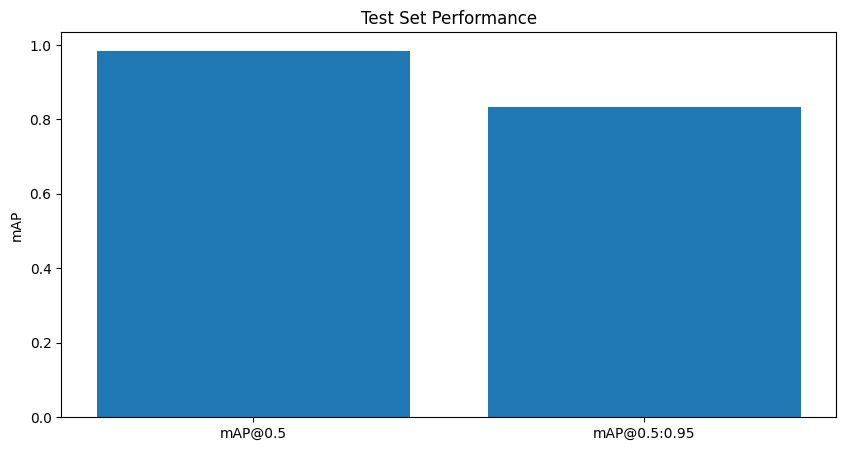

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(['mAP@0.5', 'mAP@0.5:0.95'], [map_values['map_50'], map_values['map']])
plt.title('Test Set Performance')
plt.ylabel('mAP')
plt.show()

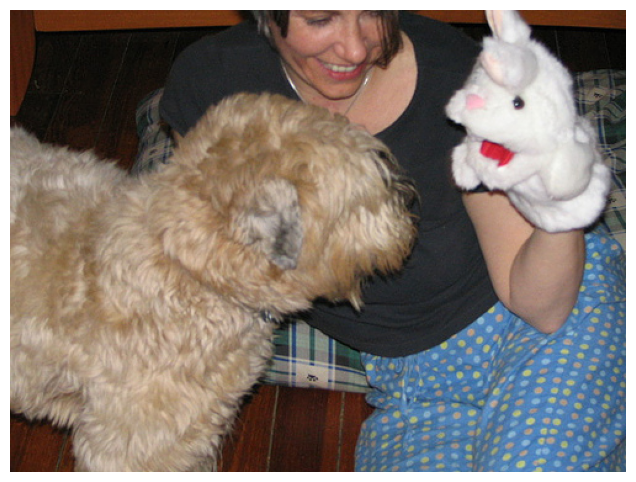

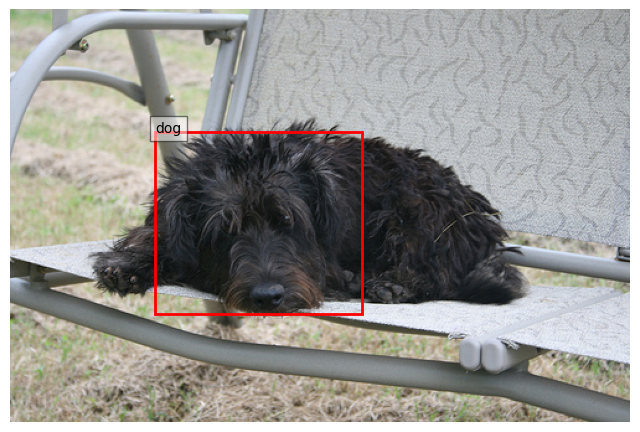

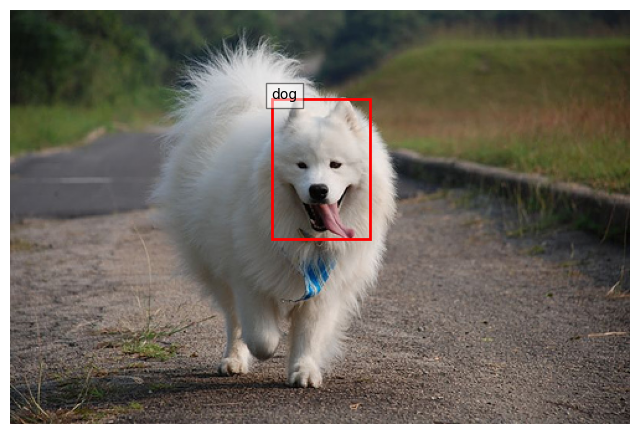

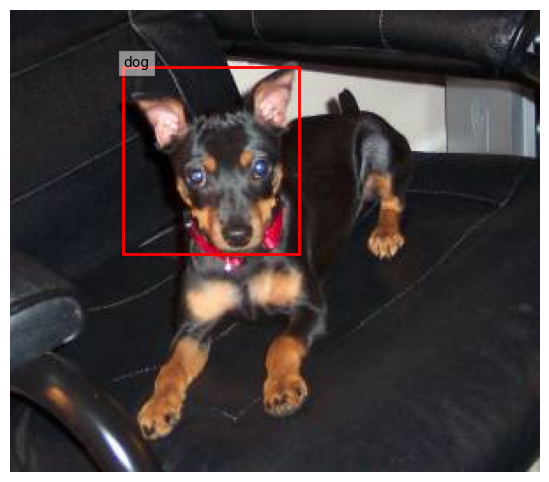

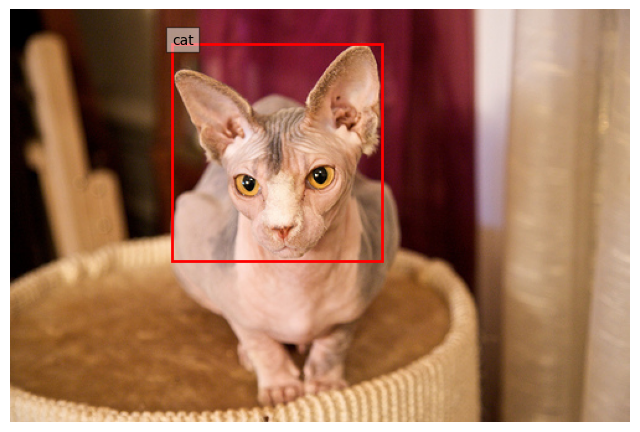

In [14]:
model.eval()
for i in range(5):
    image, target = test_dataset[i]
    image_tensor = image.to(device)
    with torch.no_grad():
        prediction = model([image_tensor])[0]
    
    # Filter predictions
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    keep = scores > 0.5
    boxes = boxes[keep]
    labels = labels[keep]
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image.permute(1, 2, 0))  # Convert tensor to HWC
    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        class_name = classes[label - 1]  # Labels start from 1
        plt.text(xmin, ymin, class_name, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
"""
I will be honest, i used internet for most of the part. i have never worked with image with annotations, so used internet
to learn it. i cannot able to generate annotation for this dataset by myself so i used predefined annotaion for this 
dataset that i found online.

I set learning rate my learning rate a bit lower than usuall because with normal LR my model was not performing good, so
i tried to lower it and it worked fine. The biggest issue with these kind of model is resources they require to run,
it took me around 5 hours just to run for 1 time i tried hyperparameter tuning to get better result so i ran model like 7 to
8 times, i was running model for whole night and check it in the morning, so this was the most frustrating part. This model 
is really computationly intensive and also require rich dataset, i need to carfully configure the hyperparameters to get the
best results. For the improvement i can say that as it require rich and big dataset we can use data augmentation to get more
images for the model and get better results. We can also use transformers based model for object detection like DETR(DEtection TRansformer)
but it reuire a really large dataset and much more resources and also take much longer to train. howerver, it delivers better
results then Faster-RNN so we can try that as well.
"""